# 1 Data Preparation

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from shapely.geometry import Point
import seaborn as sns
from scipy.spatial import cKDTree

# define central_suburbs
christchurch_city = [
    "Addington",
    "Aidanfield",
    "Aranui",
    "Avondale",
    "Avonhead",
    "Avonside",
    "Beckenham",
    "Belfast",
    "Bexley",
    "Bishopdale",
    "Bromley",
    "Broomfield",
    "Burnside",
    "Cashmere",
    "Central City",
    "Charteris Bay",
    "Christchurch Central",
    "Cracroft",
    "Dallington",
    "Diamond Harbour",
    "Edgeware",
    "Fendalton",
    "Governors Bay",
    "Halswell",
    "Harewood",
    "Hei Hei",
    "Hillmorton",
    "Hoon Hay",
    "Huntsbury",
    "Ilam",
    "Islington",
    "Kennedys Bush",
    "Linwood",
    "Lyttelton",
    "Mairehau",
    "Mairehau North",
    "Merivale",
    "New Brighton",
    "New Brighton South",
    "New Brighton Southshore",
    "Northcote",
    "Northwood",
    "Opawa",
    "Papanui",
    "Phillipstown",
    "Pineacres",
    "Redwood",
    "Riccarton",
    "Richmond",
    "Russley",
    "Shirley East",
    "Shirley West",
    "South New Brighton",
    "Southshore",
    "Somerfield",
    "St Albans",
    "St Martins",
    "Spreydon",
    "Sydenham",
    "Upper Riccarton",
    "Wainoni",
    "Waltham",
    "Woolston",
    "Yaldhurst"
]

# define the centre resions of CHC, i.e. CHC central and suburbs adjacent to it
central_and_adjacent_suburbs = [
    "Christchurch Central",
    "St Albans",
    "Edgeware",
    "Merivale",
    "Fendalton",
    "Riccarton",
    "Addington",
    "Spreydon",
    "Sydenham",
    "Waltham",
    "Phillipstown",
    "Linwood",
    "Richmond"
]

# define the coordination of the centre of CHC
cathedral_coords_proj = (1570619.145, 5180170.479)

In [2]:
# Import all files
roads = gpd.read_file(r"D:\个人文件\Lincoln University\COMP693 Industry Project\data\lds-nz-primary-land-parcels-SHP\nz-primary-land-parcels.shp")      
liquor_store_original = gpd.read_file(r"D:\个人文件\Lincoln University\COMP693 Industry Project\data\vwLicenceDetailPoints20240924\vwLicenceDetailPoints20240924.shp")  
CHC_address = gpd.read_file(r"D:\个人文件\Lincoln University\COMP693 Industry Project\data\lds-nz-addresses-SHP\nz-addresses.shp")
property_address_original=pd.read_excel(r"D:\个人文件\Lincoln University\COMP693 Industry Project\Christchurch property sales v2.xlsx")

# select appropriate variables
sub_set=['Site Coverage','Land Area m?Land$','Sale Index', 'St.No','Sale Index']

# clean data of property address by deleting null values
sale_price=property_address_original['St.No']
Q1=sale_price.quantile(0.25)
Q3=sale_price.quantile(0.75)
IQR=Q3-Q1
lower_bound=Q1-1.5*IQR
upper_bound=Q3+1.5*IQR
condition_1=~property_address_original['Category'].str[:2].isin(['RP', 'RR', 'RV', 'RB', 'RM'])   # filter out some property types
condition_2=property_address_original[sub_set].notna().all(axis=1)  # filter out null 
condition_3=sale_price.between(lower_bound,upper_bound)  # filter out outliers
property_address_original=property_address_original[condition_1 & condition_2 & condition_3]

# extract all addresses of liquor stores by filtering
liquor_store_original=liquor_store_original.drop_duplicates(subset='StreetAd_3',keep='last')
condition_1=liquor_store_original.Purpose=='Off-licence liquor store'
condition_2=liquor_store_original.Purpose=='Off-licence supermarket'
liquor_store=liquor_store_original.loc[condition_1]
supermarket=liquor_store_original.loc[condition_2]

# match location of property addresses
condition1=CHC_address['full_add_1'].isin(property_address_original['Address Complete'])
condition2=CHC_address['suburb_loc'].isin(christchurch_city)
property_address=CHC_address[condition1&condition2].drop_duplicates(subset='full_add_1')

### 1.1 Rename Column

In [3]:
property_address=pd.merge(property_address,property_address_original,left_on='full_add_1',right_on='Address Complete',how='left')
property_address=property_address[['Sale.Date','full_add_1','geometry','Site Coverage','Land Area m?Land$','Sale Index','St.No']]
new_column_name={
    'Sale.Date':'date',
    'full_add_1':'address',
    'Site Coverage':'building_area',
    'Land Area m?Land$':'nonbuilding_area',
    'Sale Index':'age',
    'St.No':'sale_price'}
property_address=property_address.rename(columns=new_column_name)
property_address['age'] = pd.to_numeric(property_address['age'], errors='coerce')

liquor_store=liquor_store[['address_1','geometry']].rename(columns={'address_1':'address'}).reset_index(drop=True)
supermarket=supermarket[['address_1','geometry']].rename(columns={'address_1':'address'}).reset_index(drop=True)

### 1.2 Distance to the nearest liqor store from property address

In [4]:
gdf_a=property_address
gdf_b=liquor_store
gdf_c=supermarket

a_coords = np.array(list(gdf_a.geometry.apply(lambda geom: (geom.x, geom.y))))
b_coords = np.array(list(gdf_b.geometry.apply(lambda geom: (geom.x, geom.y))))
c_coords = np.array(list(gdf_c.geometry.apply(lambda geom: (geom.x, geom.y))))
tree_liqor = cKDTree(b_coords)
tree_supermarket = cKDTree(c_coords)
distances, indices = tree_liqor.query(a_coords, k=1)
gdf_a['nearest_dist_liquor'] = distances.round(2)      # unit: metre
distances, indices = tree_supermarket.query(a_coords, k=1)
gdf_a['nearest_dist_supermarket'] = distances.round(2)      # unit: metre

gdf_a=property_address
property_address.head()

,date,address,geometry,building_area,nonbuilding_area,age,sale_price,nearest_dist_liquor,nearest_dist_supermarket
0,29/03/2023,"78 Kerrs Road, Avonside, Christchurch",POINT (1574263.834 5180981.602),104,774,194.0,345000,1202.10,1176.15
1,6/12/2023,"374A Pages Road, Aranui, Christchurch",POINT (1576051.79 5181730.722),43,0,197.0,280000,2199.24,982.50
2,23/12/2023,"64 Tovey Street, New Brighton, Christchurch",POINT (1578120.564 5181665.05),91,630,194.0,758500,1064.41,1216.90
3,16/03/2023,"5/6 Hendon Street, Edgeware, Christchurch",POINT (1571607.246 5182195.933),60,0,197.0,325000,495.76,964.17
4,30/10/2023,"121A Hawford Road, Opawa, Christchurch",POINT (1572815.843 5177646.228),150,452,199.0,843000,976.48,849.49


In [5]:
# the distance to city centre (Christchurch Cathedral)
coords = np.array(list(property_address['geometry'].apply(lambda geom: (geom.x, geom.y))))
dist_to_cathedral = np.sqrt((coords[:,0] - cathedral_coords_proj[0])**2 + 
                            (coords[:,1] - cathedral_coords_proj[1])**2)
property_address['dist_to_cathedral'] = dist_to_cathedral.round(2)
property_address.sample(2)

,date,address,geometry,building_area,nonbuilding_area,age,sale_price,nearest_dist_liquor,nearest_dist_supermarket,dist_to_cathedral
4411,11/09/2023,"4/10 Brockworth Place, Riccarton, Christchurch",POINT (1568576.771 5179763.403),35,116,202.0,639000,619.51,1117.83,2082.55
3156,25/05/2023,"17 Stallion Avenue, Halswell, Christchurch",POINT (1564214.58 5176264.339),234,760,200.0,845000,1277.64,1391.00,7501.76


### 1.3 Convert housing age and sales date

In [6]:
property_address['age']=203-property_address['age']

property_address['date']=pd.to_datetime(property_address['date'], dayfirst=True)
month=property_address['date'].dt.month
year=property_address['date'].dt.year
property_address['time']=(year-2023)*12+month
property_address.head(2)

,date,address,geometry,building_area,nonbuilding_area,age,sale_price,nearest_dist_liquor,nearest_dist_supermarket,dist_to_cathedral,time
0,2023-03-29,"78 Kerrs Road, Avonside, Christchurch",POINT (1574263.834 5180981.602),104,774,9.0,345000,1202.10,1176.15,3733.86,3
1,2023-12-06,"374A Pages Road, Aranui, Christchurch",POINT (1576051.79 5181730.722),43,0,6.0,280000,2199.24,982.50,5652.26,12


### 1.4 Export data

In [7]:
liquor_store.to_excel(r"D:\个人文件\Lincoln University\COMP693 Industry Project\data\Exported\liquor_store.xlsx")
property_address.to_excel(r"D:\个人文件\Lincoln University\COMP693 Industry Project\data\Exported\property_address.xlsx")
supermarket.to_excel(r"D:\个人文件\Lincoln University\COMP693 Industry Project\data\Exported\supermarket.xlsx")

# 2.1 Moran's I

In [8]:
from IPython.display import display, Math
from esda.moran import Moran
from libpysal.weights import Queen, Rook, KNN, DistanceBand

formula = r"""
I = \frac{n}{W} \times \frac{\sum_{i=1}^n \sum_{j=1}^n w_{ij} (x_i - \bar{x})(x_j - \bar{x})}{\sum_{i=1}^n (x_i - \bar{x})^2}
"""
display(Math(formula))

y = property_address['sale_price'].values

# Queen 
w_queen = Queen.from_dataframe(property_address,use_index=True)
moran_queen = Moran(y, w_queen)
print("Queen:")
print("Moran's I:", moran_queen.I)
print("p-value  :", moran_queen.p_sim)
print("")

# Rook
w_rook = Rook.from_dataframe(property_address,use_index=True)
moran_rook = Moran(y, w_rook)
print("Rook:")
print("Moran's I:", moran_rook.I)
print("p-value  :", moran_rook.p_sim)
print("")

# K-Nearest Neighbor
w_knn = KNN.from_dataframe(property_address, k=4)
moran_knn = Moran(y, w_knn)
print("KNN (k=4):")
print("Moran's I:", moran_knn.I)
print("p-value  :", moran_knn.p_sim)
print("")

# DistanceBand
w_dist = DistanceBand.from_dataframe(property_address, threshold=1000,use_index=True)
moran_dist = Moran(y, w_dist)
print("Distance Band (1000m):")
print("Moran's I:", moran_dist.I)
print("p-value  :", moran_dist.p_sim)

<IPython.core.display.Math object>

Queen:
Moran's I: 0.47802684433470577
p-value  : 0.001

Rook:
Moran's I: 0.47802684433470577
p-value  : 0.001



D:\anaconda3\envs\gis_env\lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 40 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


KNN (k=4):
Moran's I: 0.5075776023969139
p-value  : 0.001



D:\anaconda3\envs\gis_env\lib\site-packages\libpysal\weights\util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 3 islands with ids: 234, 3236, 3258.
  w = W(neighbors, weights, ids, **kwargs)
D:\anaconda3\envs\gis_env\lib\site-packages\libpysal\weights\distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 3 islands with ids: 234, 3236, 3258.
  W.__init__(


('WARNING: ', 234, ' is an island (no neighbors)')
('WARNING: ', 3236, ' is an island (no neighbors)')
('WARNING: ', 3258, ' is an island (no neighbors)')
Distance Band (1000m):
Moran's I: 0.314225521299631
p-value  : 0.001


# 2.2 Moran I (+time)

In [9]:
import pandas as pd
import numpy as np
from shapely import wkt
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler


from IPython.display import display, Math

display(Math(r"""
w_{ij} = \exp\left( - \frac{d_{ij}^2}{h_s^2} - \frac{t_{ij}^2}{h_t^2} \right), \quad w_{ii} = 0
"""))

def ensure_point(val):
    if isinstance(val, str):
        return wkt.loads(val)
    elif isinstance(val, Point):
        return val
    else:
        return np.nan

property_address = property_address.dropna(subset=['geometry', 'sale_price', 'time'])
property_address['geometry'] = property_address['geometry'].apply(ensure_point)
property_address['sale_price'] = pd.to_numeric(property_address['sale_price'], errors='coerce')

coords = np.array([[p.x, p.y] for p in property_address['geometry']])
time_array = property_address['time'].values.reshape(-1, 1)

D = euclidean_distances(coords, coords)
T = euclidean_distances(time_array, time_array)

h_s = 1000  
h_t = 3     

W = np.exp(- (D ** 2) / (h_s ** 2) - (T ** 2) / (h_t ** 2))
W = np.clip(W, 1e-9, 1)   
np.fill_diagonal(W, 0)    

y = property_address['sale_price'].values.reshape(-1, 1)
y = StandardScaler().fit_transform(y).flatten()  

def calculate_morans_I(values, W):
    y_mean = values.mean()
    y_dev = values - y_mean
    numerator = np.sum(W * np.outer(y_dev, y_dev))
    denominator = np.sum(y_dev ** 2) + 1e-9
    W_sum = np.sum(W) + 1e-9
    I = (len(values) / W_sum) * (numerator / denominator)
    return I

moran_I = calculate_morans_I(y, W)


print(f"Moran's I = {moran_I:.4f}")


<IPython.core.display.Math object>

Moran's I = 0.2877


# 3 Correlation

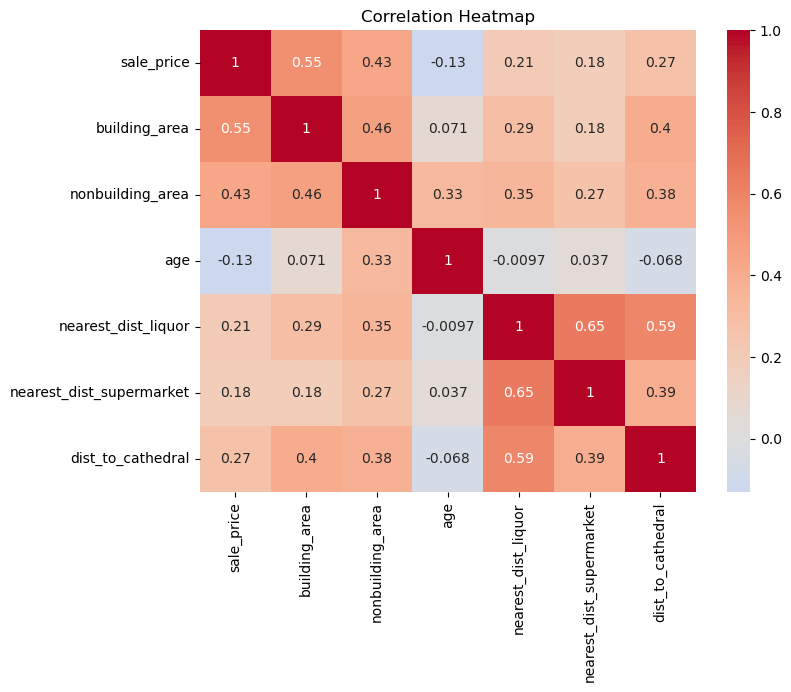

In [10]:
variables=['sale_price','building_area','nonbuilding_area','age','nearest_dist_liquor','nearest_dist_supermarket','dist_to_cathedral']
df=property_address[variables]

corr = df.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()


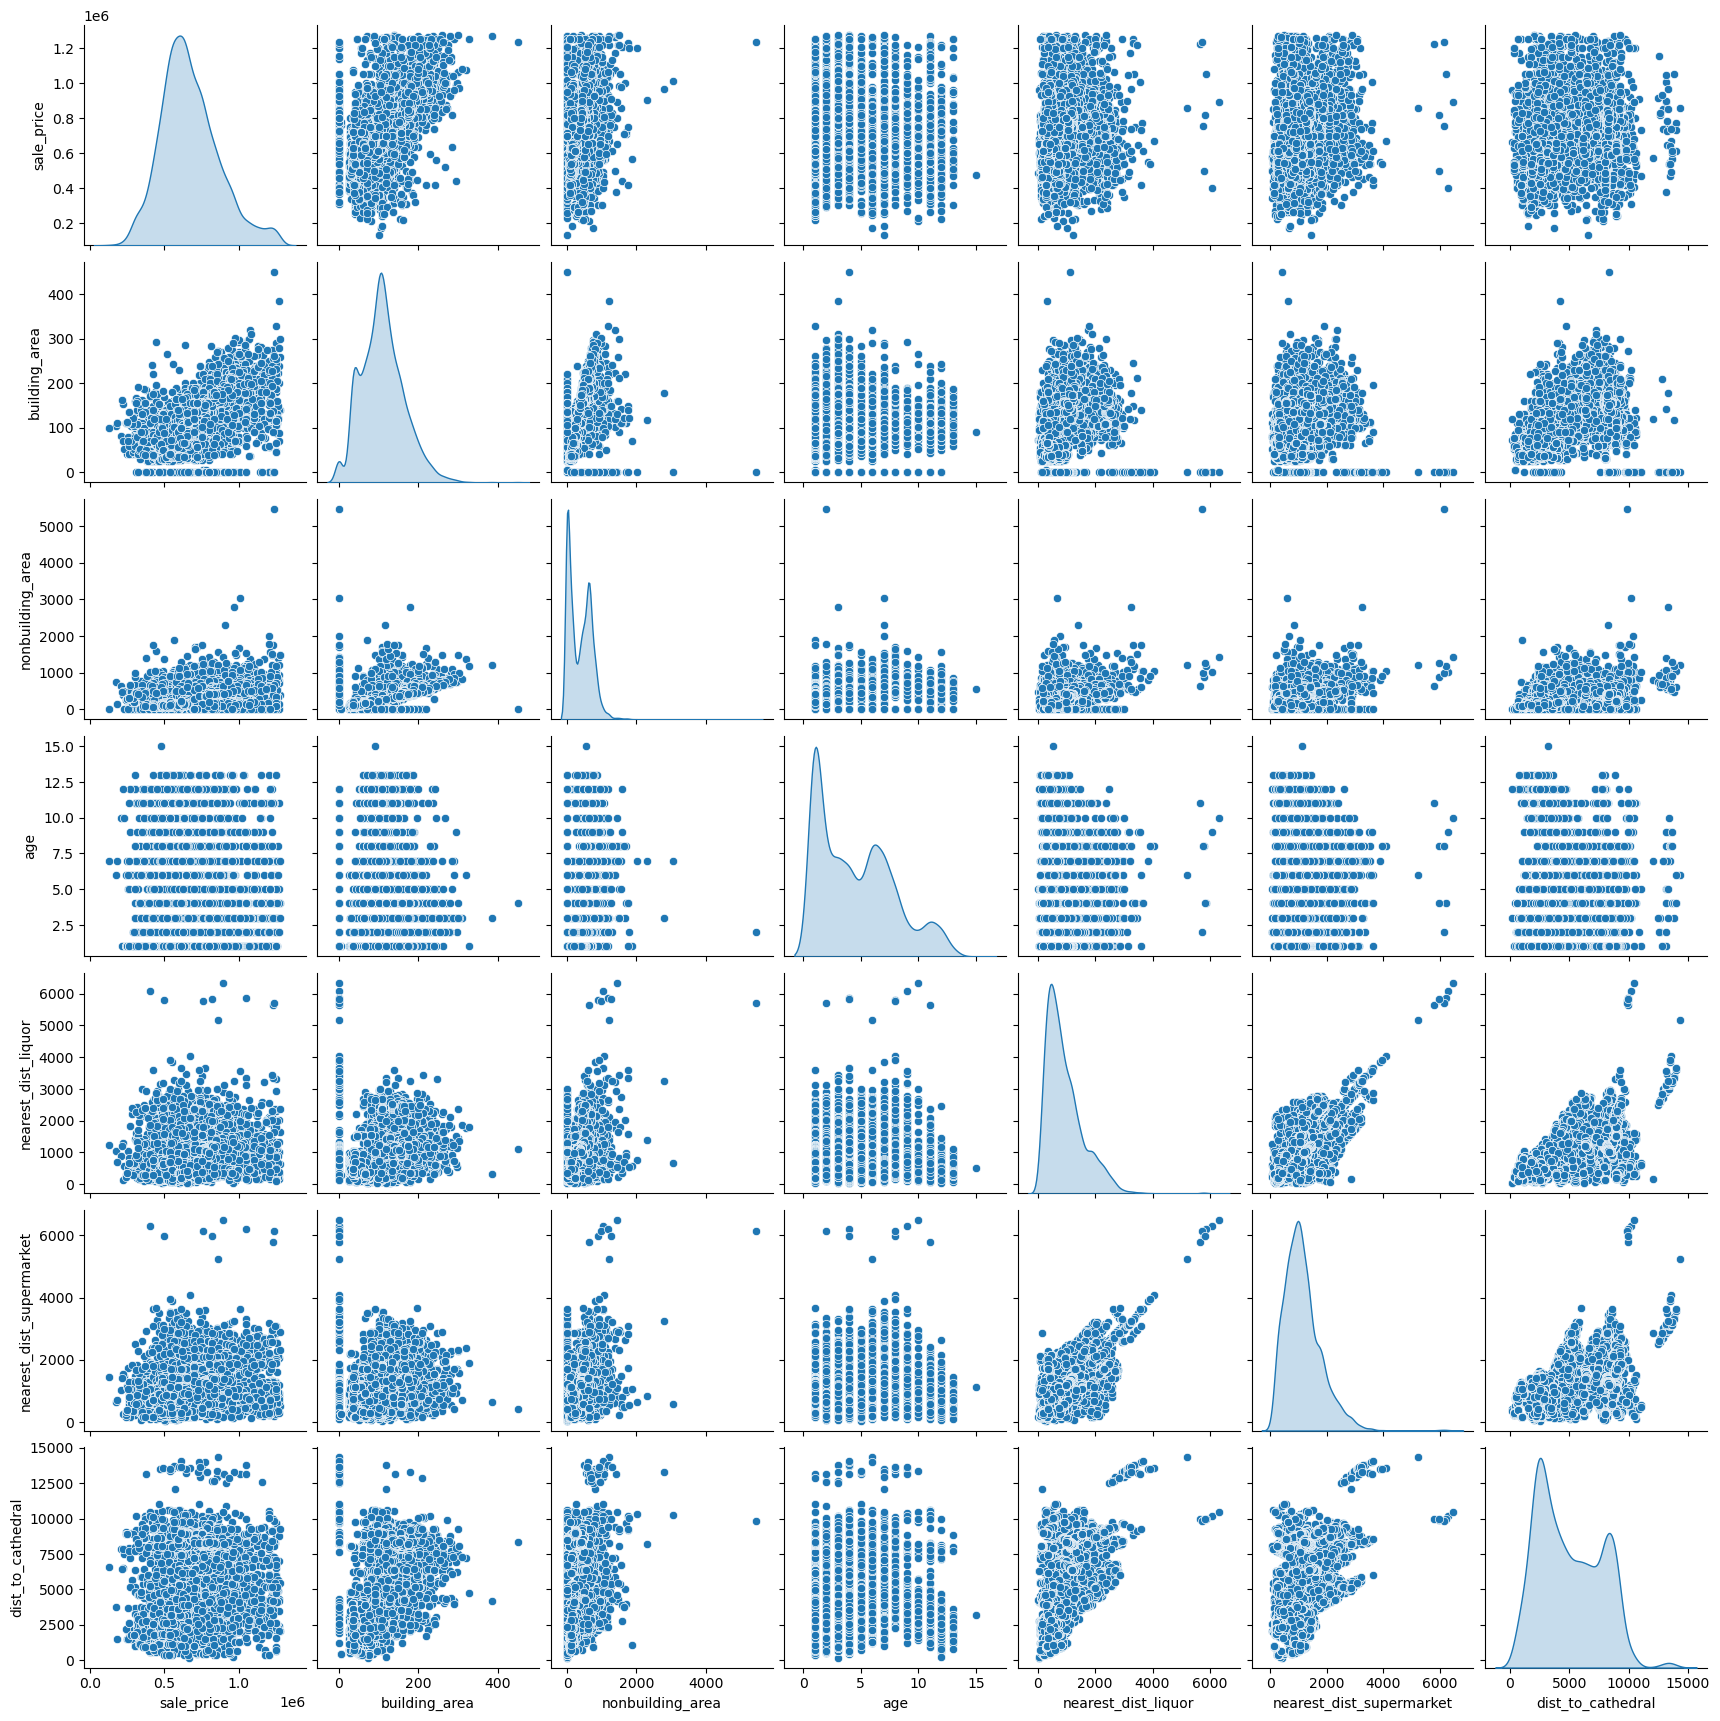

In [9]:
# pairplot
sns.pairplot(df,diag_kind="kde") 
plt.show()

# 4. Visualisation

#### 4.1 Spatial Distribution of Property, Liquor Store and Supermarket

C:\Users\frank\AppData\Local\Temp\ipykernel_18804\2700357807.py:13: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


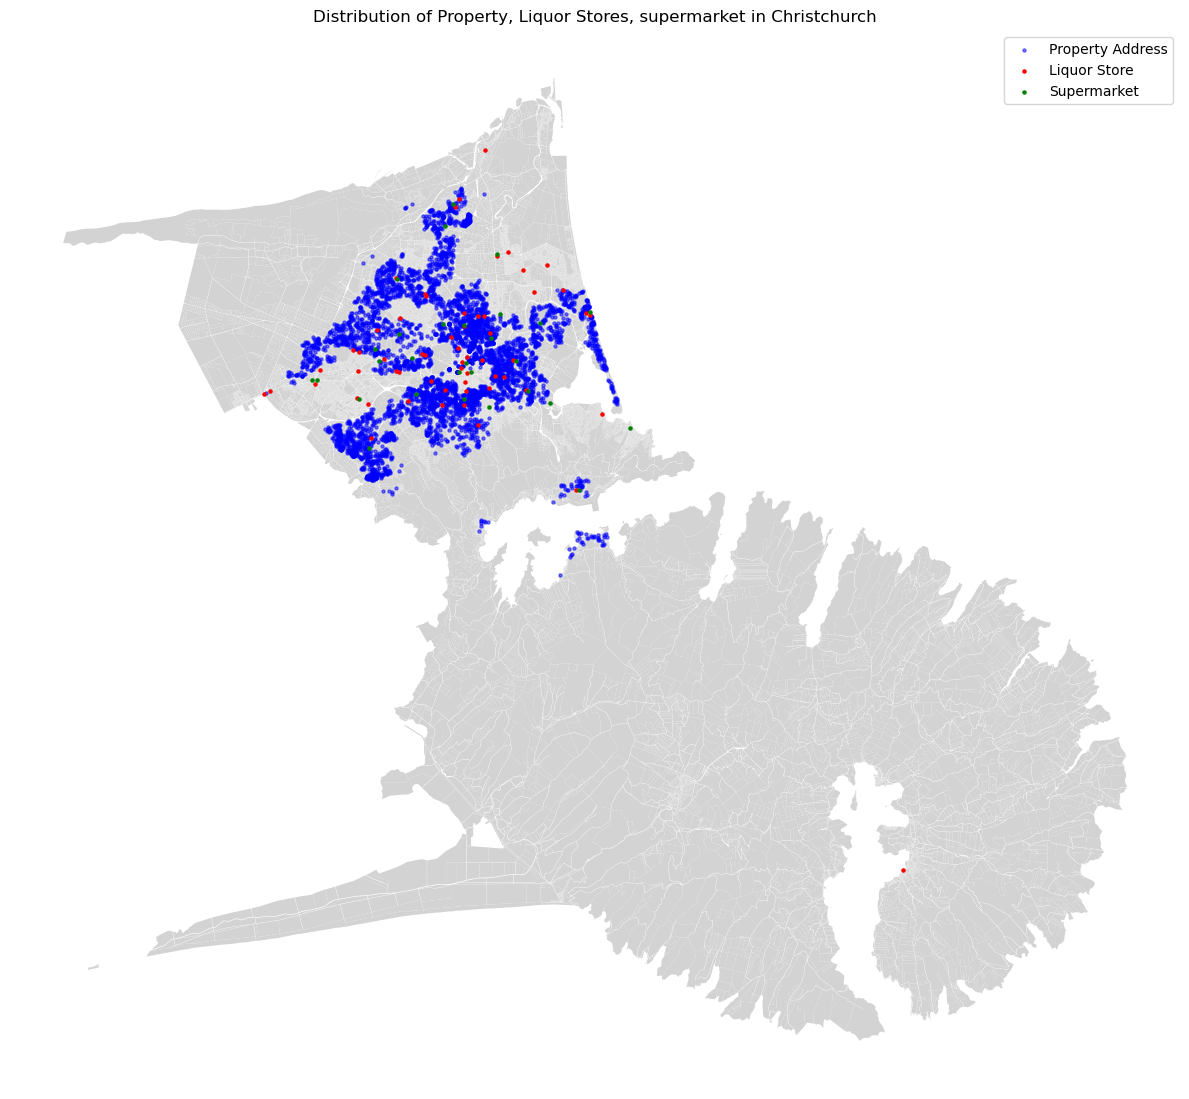

In [21]:
target_crs = roads.crs
liquor_store = liquor_store.to_crs(target_crs)
property_address = property_address.to_crs(target_crs)
supermarket=supermarket.to_crs(target_crs)

fig, ax = plt.subplots(figsize=(12, 12))

roads.plot(ax=ax, color='lightgrey', linewidth=0.5, label='Roads')
property_address.plot(ax=ax, color='blue', markersize=5, label='Property Address',alpha=0.5)
liquor_store.plot(ax=ax, color='red', markersize=5, label='Liquor Store')
supermarket.plot(ax=ax, color='green', markersize=5, label='Supermarket')

plt.legend()
plt.title("Distribution of Property, Liquor Stores, supermarket in Christchurch")
plt.axis('off')
plt.tight_layout()

plt.show()

#### 4.2 Spatial Distribution of Unit Price 

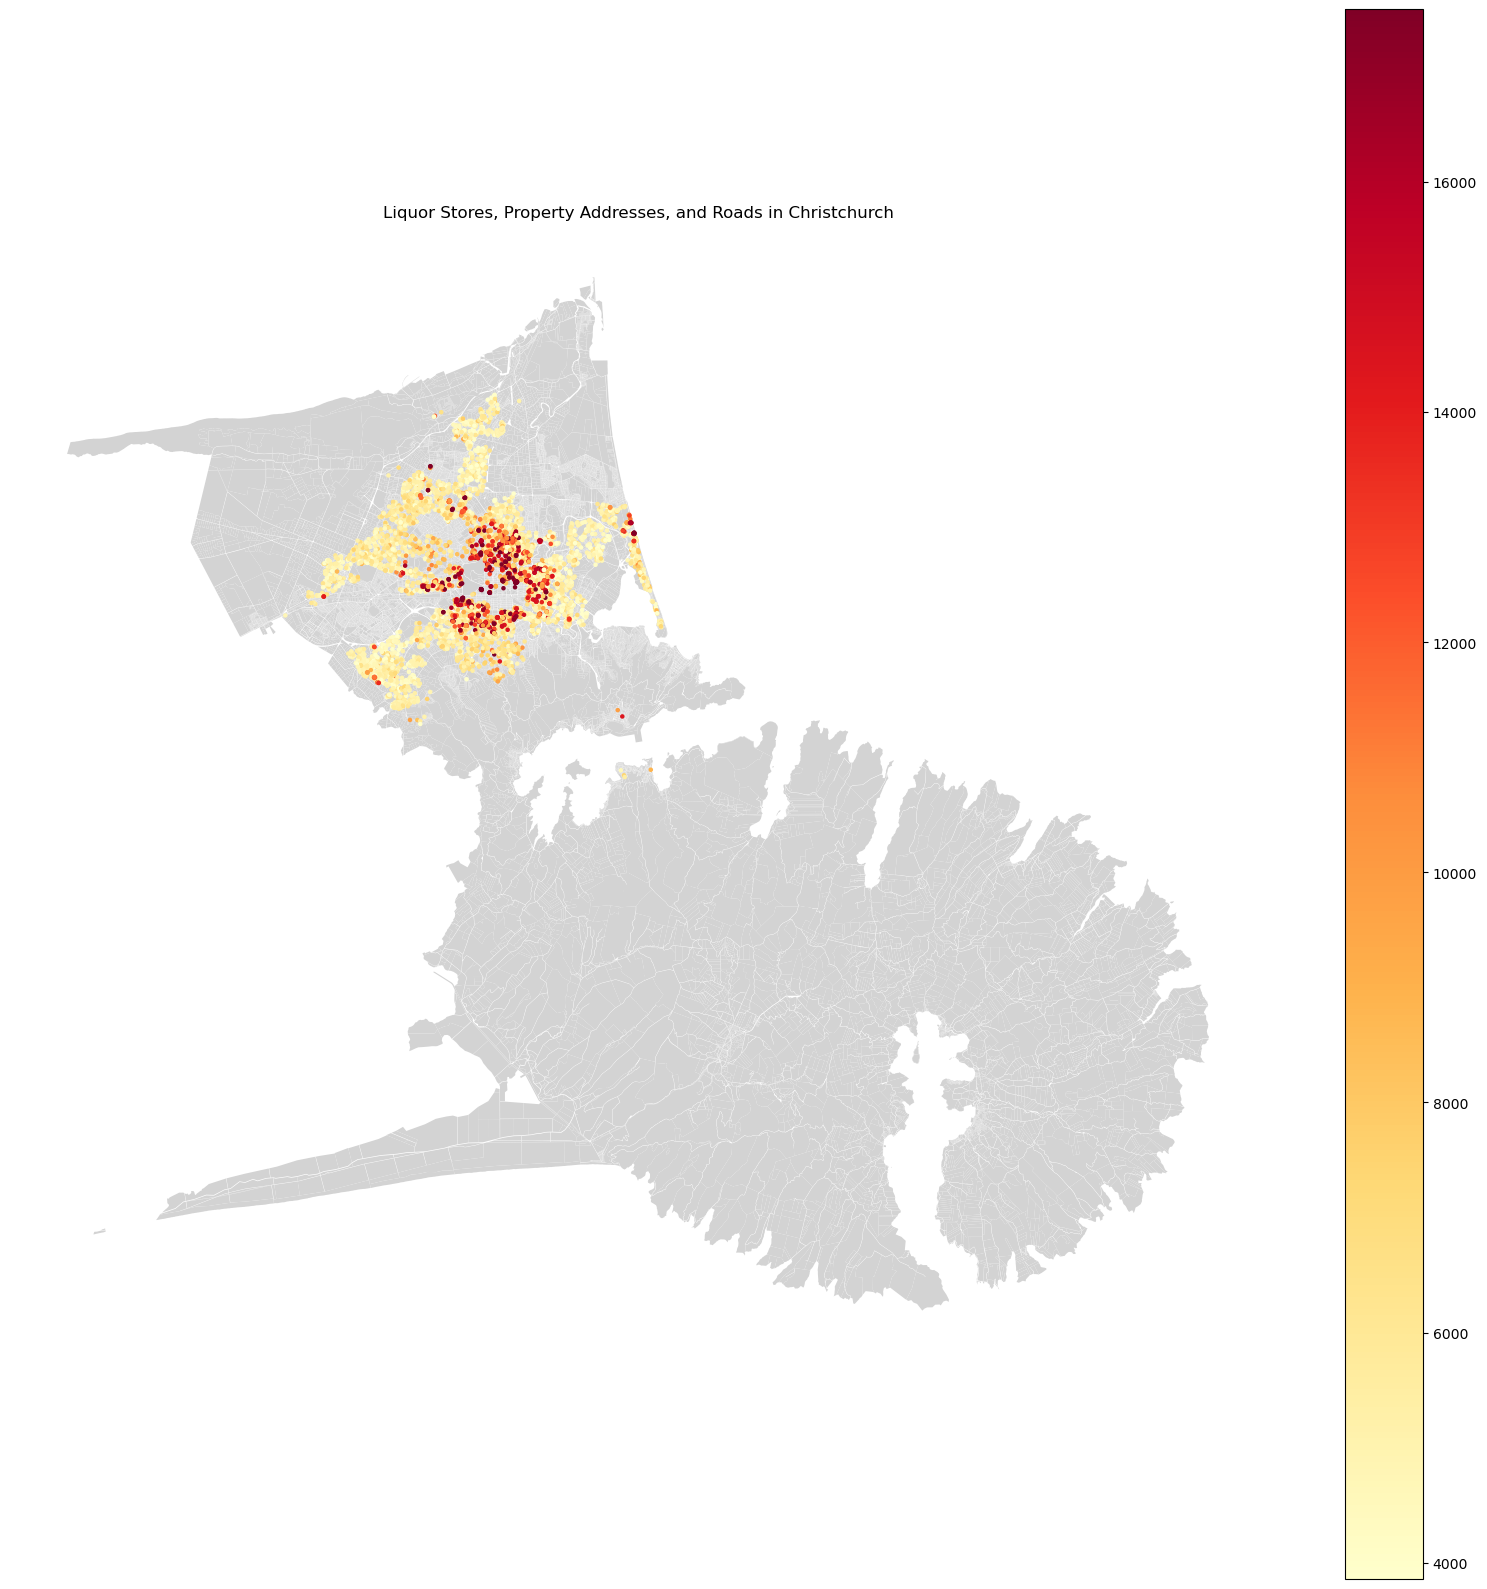

In [34]:
property_address['unit_price']=property_address['sale_price']/property_address['building_area']

target_crs = roads.crs
liquor_store = liquor_store.to_crs(target_crs)
property_address = property_address.to_crs(target_crs)
supermarket=supermarket.to_crs(target_crs)

vmin = property_address['unit_price'].quantile(0.05)
vmax = property_address['unit_price'].quantile(0.95)

fig, ax = plt.subplots(figsize=(16, 16))

roads.plot(ax=ax, color='lightgrey', linewidth=0.5, label='Roads')
property_address.plot(ax=ax, column='unit_price',cmap='YlOrRd', markersize=5, label='Property Address', legend=True, vmin=vmin,vmax=vmax)
# liquor_store.plot(ax=ax, color='black', markersize=5, label='Liquor Store')
# supermarket.plot(ax=ax, color='green', markersize=5, label='Supermarket')

plt.title("Liquor Stores, Property Addresses, and Roads in Christchurch")
plt.axis('off')
plt.tight_layout()

plt.show()

# 5. Modelling

In [11]:
import geopandas as gpd
from shapely.geometry import Point
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from scipy.spatial import cKDTree
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from shapely import wkt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white

liquor_store=pd.read_excel(r"D:\个人文件\Lincoln University\COMP693 Industry Project\data\Exported\liquor_store.xlsx")
property_address=pd.read_excel(r"D:\个人文件\Lincoln University\COMP693 Industry Project\data\Exported\property_address.xlsx")
supermarket=pd.read_excel(r"D:\个人文件\Lincoln University\COMP693 Industry Project\data\Exported\supermarket.xlsx")

### 5.1 Examine data for muticollinearity, using VIF

In [12]:
def calculate_vif(X):
    vif_dict = {}
    for i in range(X.shape[1]):
        y = X.iloc[:, i]
        X_other = X.drop(X.columns[i], axis=1)
        coef = np.linalg.lstsq(X_other, y, rcond=None)[0]
        y_pred = X_other.dot(coef)
        ss_res = ((y - y_pred)**2).sum()
        ss_tot = ((y - y.mean())**2).sum()
        r_squared = 1 - ss_res/ss_tot
        vif = 1 / (1 - r_squared)
        vif_dict[X.columns[i]] = vif
    return pd.DataFrame.from_dict(vif_dict, orient='index', columns=['VIF'])

data = property_address[['building_area','nonbuilding_area','age','nearest_dist_liquor','nearest_dist_supermarket','dist_to_cathedral']]

vif_result = calculate_vif(data)
print(vif_result)


                               VIF
building_area             1.093837
nonbuilding_area          1.512163
age                       0.915924
nearest_dist_liquor       2.228947
nearest_dist_supermarket  1.540244
dist_to_cathedral         1.569325


### 5.2 Modelling

In [13]:
property_address['geometry'] = property_address['geometry'].apply(wkt.loads)
gdf_property = gpd.GeoDataFrame(property_address, geometry='geometry')
Y = gdf_property['sale_price'].values.reshape((-1, 1))
X = gdf_property[['building_area', 'nonbuilding_area', 'age', 'nearest_dist_liquor', 'nearest_dist_supermarket','dist_to_cathedral']].values
X = StandardScaler().fit_transform(X)
coords = np.array([[point.y, point.x] for point in gdf_property.geometry])

selector = Sel_BW(coords, Y, X)
bw = selector.search() 

print(f'Optimal bandwidth: {bw}')

gwr_model = GWR(coords, Y, X, bw)
gwr_results = gwr_model.fit()

Optimal bandwidth: 108.0


In [14]:
print(gwr_results.summary())

Model type                                                         Gaussian
Number of observations:                                                5474
Number of covariates:                                                     7

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                       121280698549469.656
Log-likelihood:                                                  -72966.343
AIC:                                                             145946.685
AICc:                                                            145948.711
BIC:                                                           121280698502411.000
R2:                                                                   0.409
Adj. R2:                                                              0.408

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---

### 5.3 Boxplot of coefficient

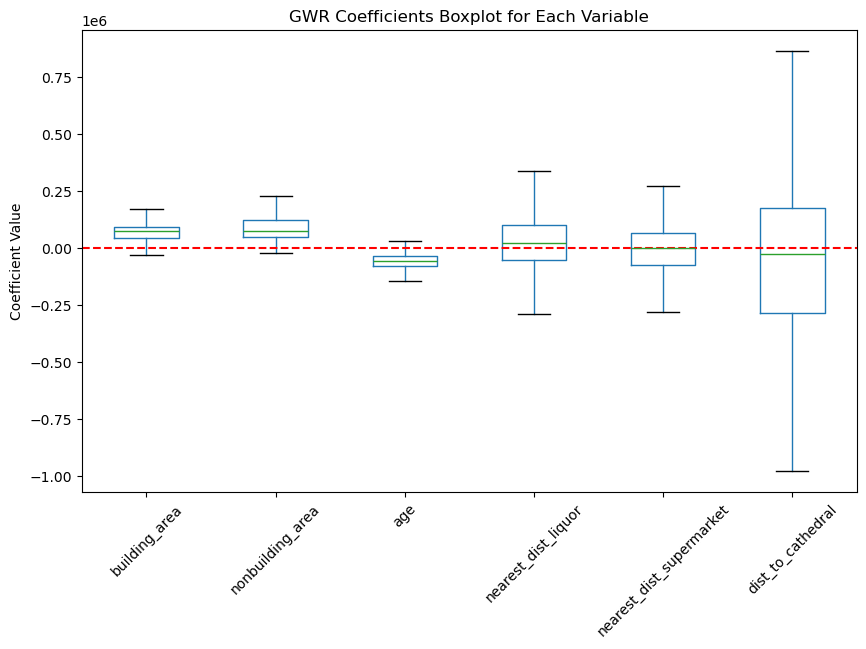

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

params = gwr_results.params  # shape (n_points, n_variables)
variables = ['Intercept', 'building_area', 'nonbuilding_area', 'age', 'nearest_dist_liquor', 'nearest_dist_supermarket','dist_to_cathedral']

df_params = pd.DataFrame(params, columns=variables)

df_params_no_intercept = df_params.drop(columns=['Intercept'])

plt.figure(figsize=(10,6))
df_params_no_intercept.boxplot(showfliers=False)
plt.axhline(0,color='red', linestyle='--')
plt.title('GWR Coefficients Boxplot for Each Variable')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45)
plt.grid(False)
plt.show()


### 5.4 Residual Analysis

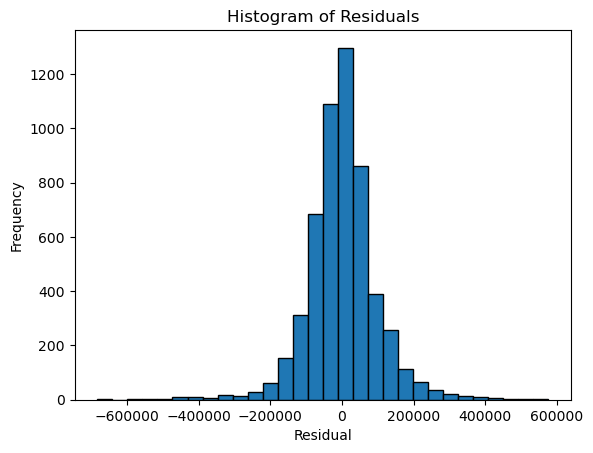

In [18]:
residuals = gwr_results.resid_response.flatten() 
gdf_property['residuals'] = residuals.flatten()
plt.hist(residuals, bins=30, edgecolor='k')
plt.title('Histogram of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

### 5.4.1 Kolmogorov-Smirnov Test for Normality

In [19]:
from scipy.stats import jarque_bera

stat, p = jarque_bera(residuals)
print(f"JB test statistic={stat:.3f}, p-value={p:.3f}") 

JB test statistic=4553.571, p-value=0.000


### 5.4.2 Independency Test

In [35]:
from libpysal.weights import KNN
from esda.moran import Moran

w = KNN.from_dataframe(gdf_property, k=8)
w.transform = 'r'

moran = Moran(gdf_property['residuals'], w)

print(f"Moran's I: {moran.I:.4f}")
print(f"p-value: {moran.p_sim:.4f}")


Moran's I: -0.0302
p-value: 0.0010


D:\anaconda3\envs\gis_env\lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


### 5.4.3 Homogeneity of Variance Test : White Test

In [21]:
X_with_const = sm.add_constant(X)

white_test = het_white(residuals, X_with_const)

lm_stat, lm_pvalue, f_stat, f_pvalue = white_test

print(f"White test LM statistic: {lm_stat:.4f}, p-value: {lm_pvalue:.4f}")
print(f"White test F statistic: {f_stat:.4f}, p-value: {f_pvalue:.4f}")

White test LM statistic: 190.6753, p-value: 0.0000
White test F statistic: 7.2795, p-value: 0.0000


### 5.4 Model equation

In [22]:
i = 110
coef = gwr_results.params[i]
variables = ['Intercept', 'building_area', 'nonbuilding_area','age', 'nearest_dist_liquor', 'nearest_dist_supermarket','dist_to_cathedral']
formula_parts = [f"{coef[j]:.3f}*{variables[j]}" if j > 0 else f"{coef[j]:.3f}" for j in range(len(coef))]
formula_str = " + ".join(formula_parts)
print(f"y = {formula_str}")

y = 398851.784 + 55860.377*building_area + 56489.717*nonbuilding_area + -41552.149*age + -142176.330*nearest_dist_liquor + 126795.294*nearest_dist_supermarket + 266261.636*dist_to_cathedral


### 5.6 Prediction Evaluation

In [15]:
y_pred = gwr_results.predy.flatten()
y_true = Y.flatten()

mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f"MAPE: {mape:.2f}%")

MAPE: 11.41%
